<a href="https://colab.research.google.com/github/olympus999/e-ariregistri_avaandmed/blob/main/Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download, import and install libraries

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install ijson

In [2]:
import os
import urllib.request
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql.types import *
from pyspark.sql.functions import col, regexp_replace, lit
from os.path import isfile
import zipfile
import json
import ast
import time
import ijson
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setup Spark and define files

In [3]:
conf = SparkConf().set("spark.driver.memory", "10g")\
                  .set("spark.executor.memory", "10g")
spark = SparkSession.builder\
          .config(conf=conf)\
          .master("local[*]")\
          .appName('avaandmed_ariregister')\
          .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

In [4]:
# spark.sparkContext.getConf().getAll()

In [5]:
folder_data = 'data'
folder_data_unpacked = os.path.join(folder_data, 'unpacked')
folder_data_spark_json = os.path.join(folder_data_unpacked, 'spark_json')

# Data is downloaded from here: https://avaandmed.ariregister.rik.ee/et/avaandmete-allalaadimine#ettepanekud-ja-tagasiside
generic_data = {
    'simple_data':            'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__lihtandmed.csv.zip',
    'generic_data':           'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__yldandmed.json.zip', # Huge file
    # 'registrikaardid':        'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__registrikaardid.json.zip',
    # 'kaardile_kantud_isikud': 'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__kaardile_kantud_isikud.json.zip',
    # 'kandevalised_isikud':    'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__kandevalised_isikud.json.zip',
    # 'osanikud':               'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__osanikud.json.zip',
    # 'kasusaajad':             'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__kasusaajad.json.zip',
    # 'kommertspandiandmed':    'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__kommertspandid.json.zip',
    # 'maarused':               'https://avaandmed.ariregister.rik.ee/sites/default/files/avaandmed/ettevotja_rekvisiidid__maarused.json.zip'
}

yearly_data = {
    # 'aruannete_yldandmed':                  'https://avaandmed.ariregister.rik.ee/sites/default/files/1.aruannete_yldandmed_kuni_31102023.zip',
    'emtak_sales_distribution':             'https://avaandmed.ariregister.rik.ee/sites/default/files/2.EMTAK_myygitulu_kuni_31102023.zip',
    # 'myygitulu_geograafiline_jaotus':       'https://avaandmed.ariregister.rik.ee/sites/default/files/3.myygitulu_geograafiline_kuni_31102023.zip',
    # 'pohinaitajad_2020_aasta_aruannetest':  'https://avaandmed.ariregister.rik.ee/sites/default/files/4.2020_aruannete_elemendid_kuni_31102023.zip',
    # 'pohinaitajad_2021_aasta_aruannetest':  'https://avaandmed.ariregister.rik.ee/sites/default/files/4.2021_aruannete_elemendid_kuni_31102023.zip',
    # 'pohinaitajad_2022_aasta_aruannetest':  'https://avaandmed.ariregister.rik.ee/sites/default/files/4.2022_aruannete_elemendid_kuni_31102023.zip',
}

# Data is downloaded to Google Drive as they only keep the last 3 years of data available on their site.
# Data is downloaded from here: https://www.emta.ee/ariklient/amet-uudised-ja-kontakt/uudised-pressiinfo-statistika/statistika-ja-avaandmed#tasutud-maksud-failid

paid_taxes = {
    'paid_taxes_2020_i_quarter':    'https://drive.google.com/uc?id=1h1-hW7sTCMlOxxvz4258W403_HC5QTJV',
    'paid_taxes_2020_ii_quarter':   'https://drive.google.com/uc?id=1qDBr9U8WtSsFucuyEkJy-Hmhx2222zpY',
    'paid_taxes_2020_iii_quarter':  'https://drive.google.com/uc?id=1LFo2bueoIcedmDUdbN6YLZN0_53HWxFY',
    'paid_taxes_2020_iv_quarter':   'https://drive.google.com/uc?id=1OIU9IlYQlRtzsccOSqB6uEHLBnq4Axst',
    'paid_taxes_2021_i_quarter':    'https://drive.google.com/uc?id=15t26vju1g3wR1Bqw7QCe7VFSIUXpgAWu',
    'paid_taxes_2021_ii_quarter':   'https://drive.google.com/uc?id=1Rz6KmBzw61T98noX4_aRWiZEiAjGUSa3',
    'paid_taxes_2021_iii_quarter':  'https://drive.google.com/uc?id=1aOJ_-KQDCs-oIFZMLqJql4IkICo5P-lk',
    'paid_taxes_2021_iv_quarter':   'https://drive.google.com/uc?id=10XyphD7LCub2B9EySdLG47KXhrJr9ipD',
    'paid_taxes_2022_i_quarter':    'https://drive.google.com/uc?id=1sU5wguPYaY2odNMM8aQRwopwm-sjL1oa',
    'paid_taxes_2022_ii_quarter':   'https://drive.google.com/uc?id=1diLKS7NhlLZg2e-c_wRYPLTTUAeTdJxP',
    'paid_taxes_2022_iii_quarter':  'https://drive.google.com/uc?id=1j0aeqXmzG3gdmcJkAZOvC_T_TfXnjNhA',
    'paid_taxes_2022_iv_quarter':   'https://drive.google.com/uc?id=1TGiL1zc_WPSTai8DrbxXSLaoVWXg11Qm',
    'paid_taxes_2023_i_quarter':    'https://drive.google.com/uc?id=1gsCyYuKYjN-nP-NdYWCYuMQZXRU8hpV6',
    'paid_taxes_2023_ii_quarter':   'https://drive.google.com/uc?id=1sskcbN0cAIaD8H4_34AyRxv2AwJliF1Q',
    'paid_taxes_2023_iii_quarter':  'https://drive.google.com/uc?id=1DPVmFwe6BkjD_j_VegXMJaLoyR7z9pcu',
}

all_data = {**generic_data, **yearly_data, **paid_taxes}

In [6]:
# Schemas for files

key_taxes = 'paid_taxes'

csv_kwargs = {
  'encoding':     'iso8859-1',
  'header':       True,
  'inferSchema':  True,
  'sep':          ';'
}

reg_code                        = "Reg. Code"
company_name                    = "Company Name"
company_type                    = "Company Type"
registered_in_the_vat_register  = "Registered in the VAT register"
emtak_code                      = "EMTAK Code"
county                          = "County"
national_taxes                  = "National Taxes"
labor_taxes_and_payments        = "Labor Taxes And Payments"
turnover                        = "Turnover"
employees                       = "Employees"
period                          = "Period"

schemas = {
  key_taxes :
    StructType([
      StructField(reg_code,                       StringType(), nullable=True),
      StructField(company_name,                   StringType(), nullable=True),
      StructField(company_type,                   StringType(), nullable=True),
      StructField(registered_in_the_vat_register, StringType(), nullable=True),
      StructField(emtak_code,                     StringType(), nullable=True),
      StructField(county,                         StringType(), nullable=True),
      StructField(national_taxes,                 StringType(), nullable=True), # StringType -> ´float´ is changed later, after numbers are fixed
      StructField(labor_taxes_and_payments,       StringType(), nullable=True), # StringType -> ´float´ is changed later, after numbers are fixed
      StructField(turnover,                       StringType(), nullable=True), # StringType -> ´float´ is changed later, after numbers are fixed
      StructField(employees,                      IntegerType(), nullable=True),
      StructField(period,                         StringType(), nullable=True),
    ])
}

# Functions

In [7]:
def mkdir(p):
  if not os.path.isdir(p):
    os.makedirs(p)

def get_filename(url: str, key: str = None) -> str:
  if key is not None and is_key_taxes(key):
    return key + '.csv'
  return url.split('/')[-1]

def save_avaandmed(key: str, url: str, overwrite=False) -> str:
  """CSV files will be saved to folder ´unpacked´"""
  file_name = get_filename(url, key)
  if file_name.endswith('.csv'):
    file_path_name = f"{folder_data_unpacked}/{file_name}"
  else:
    file_path_name = f"{folder_data}/{file_name}"
  if overwrite or not os.path.isfile(file_path_name):
    urllib.request.urlretrieve(url, file_path_name)

  return file_path_name

def file_path_unpacked(key: str) -> str:
  url = all_data[key]
  file_name = get_filename(url, key)
  head, _sep, tail = file_name.rpartition('.zip')
  path = os.path.join(folder_data_unpacked, (head + tail))

  if not is_json_or_csv(path):
    path = path + '.csv' # ´.csv´ is missing in some cases

  return path

def file_path_spark_json(key: str) -> str:
  url = all_data[key]
  file_name = get_filename(url)
  head, _sep, tail = file_name.rpartition('.zip')

  return os.path.join(folder_data_spark_json, (head + tail))

def create_dirs():
  mkdir(folder_data)
  mkdir(folder_data_unpacked)
  mkdir(folder_data_spark_json)

def download_files():
  for key, value in all_data.items():
    print('downloaded', key, '-', save_avaandmed(key, value))

def unpack_files():
  for f in os.listdir(folder_data):
    p = os.path.join(folder_data, f)
    if not os.path.isdir(p):
      with zipfile.ZipFile(p, "r") as zip_ref:
        zip_ref.extractall(folder_data_unpacked)
        print('unpacked', '-', p, 'to', folder_data_unpacked)

def fix_tax_numbers(df):
  def re_space(column_name: str):
    return regexp_replace(col(column_name), ' ', '')

  def re_comma(column_name: str):
    return regexp_replace(col(column_name), ',', '.')

  df = df.withColumn(national_taxes, re_space(national_taxes))\
          .withColumn(national_taxes, re_comma(national_taxes))\
          .withColumn(national_taxes, col(national_taxes).cast('float'))\
          .withColumn(labor_taxes_and_payments, re_space(labor_taxes_and_payments))\
          .withColumn(labor_taxes_and_payments, re_comma(labor_taxes_and_payments))\
          .withColumn(labor_taxes_and_payments, col(labor_taxes_and_payments).cast('float'))\
          .withColumn(turnover, re_space(turnover))\
          .withColumn(turnover, re_comma(turnover))\
          .withColumn(turnover, col(turnover).cast('float'))

  return df

def json_to_table(path: str, key: str):
  df = spark.read.json(path)
  create_table(df, key)

def csv_to_table(path: str=None, key: str=None, df: pyspark.sql.dataframe.DataFrame=None):
  assert (path is not None and key is not None) or (df is not None and key is not None), \
    "Either ´path´ and ´key´ are not ´None´ OR ´df´ and ´key´ are not ´None´"

  if df is None:
    csv_kwargs['path'] = path
    df = spark.read.csv(**csv_kwargs)

  create_table(df, key)

def create_table(df, key):
  print(f'Trying to create table ´{key}´ - ', end="")
  df.createOrReplaceTempView(key)
  print(f'Done!')

def is_json(path: str) -> bool:
  return path.endswith('.json')

def is_csv(path: str) -> bool:
  return path.endswith('.csv')

def is_json_or_csv(path: str) -> bool:
  return is_json(path) or is_csv(path)


def is_key_taxes(key: str) -> bool:
  return key.startswith(key_taxes)

def modify_json_for_spark(path: str, path_spark: str):
  # Spark expectes certain JSON format.
  # The function changes the following:
  ## [
  ##   { [record] },
  ##   { [record] }
  ## ]
  # to
  ## { [record] }
  ## { [record] }

  if is_json(path):
    print('Starting to modify JSON ', path, end="")
    start_time = time.time()
    temp_path = 'temp.json'

    # Parsing with ijson because some files are quite big in size.
    with open(path, 'r') as f:
      with open(path_spark, 'w') as json_objects:
        for n in ijson.items(f, 'item', use_float=True):
          json_objects.write(json.dumps(n) + '\n')

    time_it_took = time.time() - start_time
    print(' - done! - Time:', round(time_it_took, 1), 'seconds')
  else:
    print('NOT JSON path:', path)

def modify_downloaded_jsons():
  for key in all_data.keys():
    path = file_path_unpacked(key)
    path_spark = file_path_spark_json(key)
    modify_json_for_spark(path, path_spark)

def create_temp_tables():
  # Separate tax files and other files
  d = all_data.copy()
  tax_files = {key: d[key] for key in d.keys() if is_key_taxes(key)}
  other_files = {key: d[key] for key in d.keys() if key not in tax_files.keys()}

  # Other files into tables
  for key in other_files.keys():
    path = file_path_unpacked(key)
    if path.endswith('.json'):
      path = file_path_spark_json(key)
      json_to_table(path, key)
    elif path.endswith('.csv'):
      csv_to_table(path, key)

  # Tax data we want in one table
  df = read_tax_files(tax_files)
  csv_to_table(key=key_taxes, df=df)

def read_tax_files(tax_files):
  df = spark.createDataFrame([], schemas[key_taxes])
  schema_csv_kwargs = csv_kwargs.copy()
  schema_csv_kwargs['schema'] = schemas[key_taxes]

  for key in tax_files.keys():
    schema_csv_kwargs['path'] = file_path_unpacked(key)
    period_value = key.split('_', maxsplit=2)[-1]
    t1 = spark.read.csv(**schema_csv_kwargs)\
          .withColumn(period, lit(period_value))
    df = df.union(t1)

  df = fix_tax_numbers(df)

  return df

In [8]:
create_dirs()

download_files()

unpack_files()

modify_downloaded_jsons()

create_temp_tables()

downloaded simple_data - data/ettevotja_rekvisiidid__lihtandmed.csv.zip
downloaded generic_data - data/ettevotja_rekvisiidid__yldandmed.json.zip
downloaded emtak_sales_distribution - data/2.EMTAK_myygitulu_kuni_31102023.zip
downloaded paid_taxes_2020_i_quarter - data/unpacked/paid_taxes_2020_i_quarter.csv
downloaded paid_taxes_2020_ii_quarter - data/unpacked/paid_taxes_2020_ii_quarter.csv
downloaded paid_taxes_2020_iii_quarter - data/unpacked/paid_taxes_2020_iii_quarter.csv
downloaded paid_taxes_2020_iv_quarter - data/unpacked/paid_taxes_2020_iv_quarter.csv
downloaded paid_taxes_2021_i_quarter - data/unpacked/paid_taxes_2021_i_quarter.csv
downloaded paid_taxes_2021_ii_quarter - data/unpacked/paid_taxes_2021_ii_quarter.csv
downloaded paid_taxes_2021_iii_quarter - data/unpacked/paid_taxes_2021_iii_quarter.csv
downloaded paid_taxes_2021_iv_quarter - data/unpacked/paid_taxes_2021_iv_quarter.csv
downloaded paid_taxes_2022_i_quarter - data/unpacked/paid_taxes_2022_i_quarter.csv
downloaded pa

### EMTAK codes

Get different EMTAK codes with labels, sorted by most common codes.
EMTA Code shows the field of business the company is in, one company can have multiple EMTAK Codes

In [9]:
q = \
"""
  WITH extracted_emtak AS (
    SELECT
      element_at(yldandmed.teatatud_tegevusalad.emtak_kood, 1) AS emtak_kood,
      element_at(yldandmed.teatatud_tegevusalad.emtak_tekstina, 1) AS emtak_tekstina
    FROM generic_data
    WHERE array_size(yldandmed.teatatud_tegevusalad) == 1),
  unique_emtak AS (
    SELECT DISTINCT emtak_kood, emtak_tekstina, count(*) as count
    FROM extracted_emtak
    GROUP BY emtak_kood, emtak_tekstina)
  SELECT * FROM unique_emtak ORDER BY count DESC
"""
emtak_codes = spark.sql(q).cache()
emtak_codes.show(20, truncate=False)

+----------+-----------------------------------------------------------------------------+-----+
|emtak_kood|emtak_tekstina                                                               |count|
+----------+-----------------------------------------------------------------------------+-----+
|70221     |Ärinõustamine jm juhtimisalane nõustamine                                    |12692|
|68321     |Hoonete ja üürimajade haldus (korteriühistud, elamuühistud, hooneühistud jms)|12289|
|68201     |Enda või renditud kinnisvara üürileandmine ja käitus                         |11999|
|41201     |Elamute ja mitteeluhoonete ehitus                                            |10001|
|62011     |Programmeerimine                                                             |9736 |
|96021     |Juuksuri- ja muu iluteenindus                                                |8182 |
|47911     |Jaemüük posti või Interneti teel                                             |6761 |
|69202     |Raamatupidamine, m

### Filter companies and get details

Filter companies by EMTAK code and extract contact details.

In [17]:
q = """
  WITH selected_companies AS (
    SELECT
      ariregistri_kood as ariregistri_kood,
      yldandmed.teatatud_tegevusalad.emtak_kood as emtak_kood,
      yldandmed.teatatud_tegevusalad.emtak_tekstina as emtak_tekstina,
      yldandmed.aadressid[0].ehak_nimetus as ehak_nimetus, -- As of currently ´yldandmed.aadressid´ always contains 1 address
      yldandmed.aadressid[0].riik as riik,
      yldandmed.aadressid[0].riik_tekstina as riik_tekstina,
      array_compact(
        TRANSFORM(yldandmed.sidevahendid, elem ->
          CASE
            WHEN elem.liik_tekstina = 'Mobiiltelefon' THEN elem.sisu
            ELSE NULL
          END
      )) AS mobiiltelefon, -- In some cases there are multiple contact numbers for example.
      array_compact(
        TRANSFORM(yldandmed.sidevahendid, elem ->
          CASE
            WHEN elem.liik_tekstina = 'Elektronposti aadress' THEN elem.sisu
            ELSE NULL
          END
      )) AS email
    FROM generic_data
    WHERE array_contains(yldandmed.teatatud_tegevusalad.emtak_kood, '62011')
    and array_size(yldandmed.teatatud_tegevusalad.emtak_kood) = 1
  )
  SELECT * FROM selected_companies
"""

filtered_companies = spark.sql(q).cache()
filtered_companies.show(20, truncate=False)

+----------------+----------+------------------+--------------------------------------------+----+-------------+----------------+------------------------------+
|ariregistri_kood|emtak_kood|emtak_tekstina    |ehak_nimetus                                |riik|riik_tekstina|mobiiltelefon   |email                         |
+----------------+----------+------------------+--------------------------------------------+----+-------------+----------------+------------------------------+
|11728851        |[62011]   |[Programmeerimine]|Kesklinna linnaosa, Tallinn, Harju maakond  |EST |Eesti        |[]              |[jeepld@gmail.com]            |
|16739552        |[62011]   |[Programmeerimine]|Kesklinna linnaosa, Tallinn, Harju maakond  |EST |Eesti        |[]              |[info@044.ai]                 |
|14809610        |[62011]   |[Programmeerimine]|Haabneeme alevik, Viimsi vald, Harju maakond|NULL|NULL         |[+372 5541173]  |[0x00@bolshakov.ee]           |
|16508930        |[62011]   |[Prog

### paid taxes

In [18]:
sum_national_taxes = "National Taxes (in Billions €)"
sum_labor_taxes_and_payments = "Labor Taxes and Payments (in Billions €)"
sum_turnover = "Turnover (in Billions €)"
sum_employees = "Employees (in Thousands)"

q = """
  SELECT
    period,
    ROUND(SUM(`{national_taxes}`) / 1000000000, 2) AS `{sum_national_taxes}`,
    ROUND(SUM(`{labor_taxes_and_payments}`) / 1000000000, 2) AS `{sum_labor_taxes_and_payments}`,
    ROUND(SUM(`{turnover}`) / 1000000000, 2) AS `{sum_turnover}`,
    ROUND(SUM(`{employees}`) / 1000, 2) AS `{sum_employees}`
  FROM paid_taxes
  GROUP BY period
  SORT BY period
""".format(
      national_taxes=national_taxes,
      sum_national_taxes=sum_national_taxes,

      labor_taxes_and_payments=labor_taxes_and_payments,
      sum_labor_taxes_and_payments=sum_labor_taxes_and_payments,

      turnover=turnover,
      sum_turnover=sum_turnover,

      employees=employees,
      sum_employees=sum_employees
    )
res = spark.sql(q).cache()
res.show(50, truncate=False)

df_res = res.toPandas()
df_res = df_res.set_index('period')

+----------------+------------------------------+----------------------------------------+------------------------+------------------------+
|period          |National Taxes (in Billions €)|Labor Taxes and Payments (in Billions €)|Turnover (in Billions €)|Employees (in Thousands)|
+----------------+------------------------------+----------------------------------------+------------------------+------------------------+
|2020_i_quarter  |2.59                          |1.41                                    |19.56                   |693.31                  |
|2020_ii_quarter |2.38                          |1.33                                    |18.03                   |682.14                  |
|2020_iii_quarter|2.66                          |1.41                                    |19.38                   |628.01                  |
|2020_iv_quarter |2.64                          |1.4                                     |21.52                   |617.62                  |
|2021_i_quart

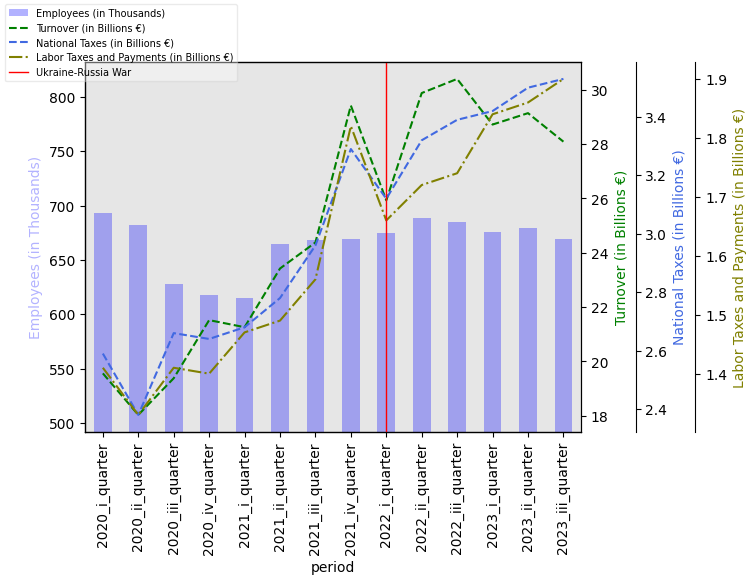

In [19]:
# pd.options.plotting.backend = "matplotlib"

kwargs = {'rot': 90}

# Employees
color = 'blue'
alpha = 0.3
ax = df_res[sum_employees].plot(kind='bar', color=color, alpha=alpha, **kwargs)
ax.set_ylabel(sum_employees, color=color, alpha=alpha)
ax.set_ylim([df_res[sum_employees].min() * 0.8, df_res[sum_employees].max()*1.2])

# Turnover
color = 'green'
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1))
df_res[sum_turnover].plot(style='--', color=color, ax=ax2, **kwargs)
ax2.set_ylabel(sum_turnover, color=color)

# National tax
color = 'royalblue'
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.11))
df_res[sum_national_taxes].plot(style='--', color=color, ax=ax2, **kwargs)
ax2.set_ylabel(sum_national_taxes, color=color)

# Labor taxes
color = 'olive'
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.23))
df_res[sum_labor_taxes_and_payments].plot(style='-.', color=color, ax=ax2, **kwargs)
ax2.set_ylabel(sum_labor_taxes_and_payments, color=color)

ax.set_facecolor((0.9, 0.9, 0.9))

plt.axvline(x=8, color='red', label='Ukraine-Russia War', linestyle='-', linewidth=1, alpha=1)

ax.figure.legend(loc=2, framealpha=0.4, fontsize=7)

In [ ]:
spark.stop()